# DA5401 A4: GMM-Based Synthetic Sampling for Imbalanced Data  

## 1) Problem Statement :

In this assignment, we address the challenge of **fraud detection** using a highly imbalanced dataset, where fraudulent transactions represent only a tiny fraction of the total data. This imbalance poses a major challenge for standard classifiers, as they tend to favor the majority (non-fraud) class and fail to capture the nuances of the minority (fraudulent) class.  

The main goal is to create a **balanced training set** that allows the classifier to effectively learn fraud patterns without overfitting or misclassifying. To achieve this, we implement a **Gaussian Mixture Model (GMM)-based synthetic data generation pipeline**, which leverages probabilistic modeling to generate realistic synthetic samples for the minority class.  

Finally, the impact of this GMM-based sampling is evaluated against a **baseline model**, with particular emphasis on **precision, recall, and F1-score** for the minority class, since these metrics are more informative than overall accuracy in the context of imbalanced classification.  


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

RANDOM_STATE = 42

# Part A: Baseline Model and Data Analysis
## 1) Data Loading and Analysis

Shape: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64
Class
0    284315
1       492
Name: count, dtype: int64


/tmp/ipykernel_29607/1969720966.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")


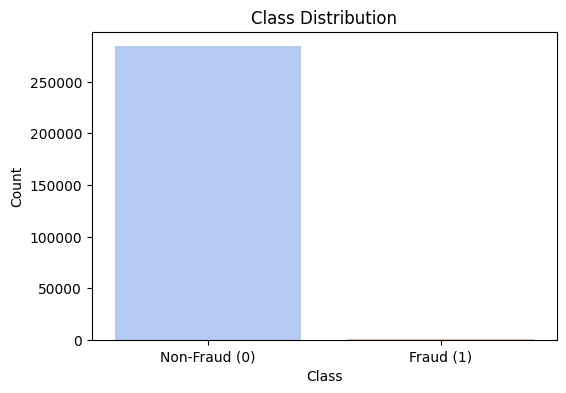

/tmp/ipykernel_29607/1969720966.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")


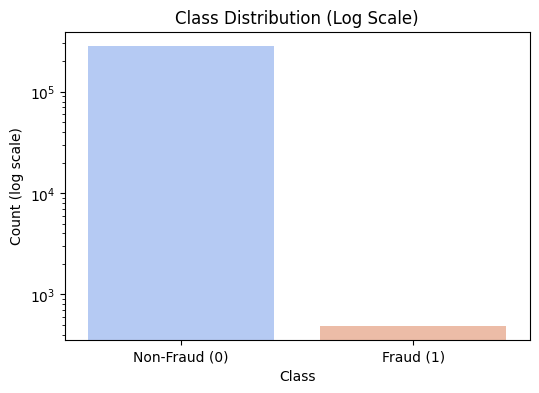

In [2]:
# Load dataset (ensure creditcard.csv is in the same folder)
df = pd.read_csv("/mnt/c/Users/ghosh/Downloads//creditcard.csv")

print('Shape:', df.shape)
print(df['Class'].value_counts())

# Class distribution
class_counts = df['Class'].value_counts()
print(class_counts)

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")
plt.xticks([0,1], ["Non-Fraud (0)", "Fraud (1)"])
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")
plt.yscale("log")   # <-- log scale
plt.xticks([0,1], ["Non-Fraud (0)", "Fraud (1)"])
plt.ylabel("Count (log scale)")
plt.title("Class Distribution (Log Scale)")
plt.show()


## Class Distribution Analysis:

The dataset is extremely imbalanced.  
- **Non-Fraud (0): ~284,000 samples**  
- **Fraud (1): ~492 samples**  

This shows that fraud cases form only a very small fraction of the data compared to non-fraud cases.  
Such imbalance can lead models to be biased toward predicting the majority class, so resampling or imbalance handling techniques are necessary.

On the normal scale, the Fraud class is almost invisible, compared to Non Fraud classes.
On log scale, we can see that Fraud cases are present still but extremely rare.

###  Data Preparation and Splitting  

The dataset is first separated into **features (X)** and **target labels (y)**.  
We then perform a **train-test split** while preserving the class distribution using stratified sampling to ensure that the imbalance is retained in both sets. Finally, we apply **feature scaling (StandardScaler)** so that all features are normalized, which is important for models like Logistic Regression and clustering-based methods.  


In [3]:
X = df.drop('Class', axis=1)
y = df['Class']

# Split data (retain imbalance in test set)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2. Baseline Logistic Regression Model  

As the starting point, we train a **baseline Logistic Regression model** on the imbalanced dataset without applying any rebalancing techniques.  
- This helps us understand how the classifier performs under the original skewed class distribution.  
- We evaluate the model using **classification metrics** (precision, recall, F1-score) and visualize the results with a **confusion matrix** to clearly observe misclassifications between the majority and minority classes.  


In [4]:
log_reg_base = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
log_reg_base.fit(X_train_scaled, y_train)
y_pred_base = log_reg_base.predict(X_test_scaled)



### 3. Baseline Evaluation:

The trained baseline Logistic Regression model is now evaluated on the test set.  
We present the **classification report** (precision, recall, F1-score) and the **confusion matrix** to analyze the performance, with particular focus on the minority class detection.  


Baseline Logistic Regression Results:
              precision    recall  f1-score   support

           0     0.9993    0.9998    0.9996     85295
           1     0.8505    0.6149    0.7137       148

    accuracy                         0.9991     85443
   macro avg     0.9249    0.8073    0.8566     85443
weighted avg     0.9991    0.9991    0.9991     85443



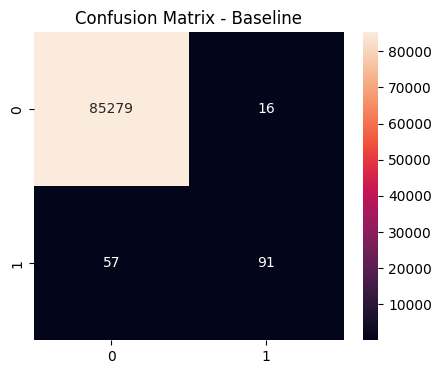

In [5]:
# Baseline metrics
print("Baseline Logistic Regression Results:")
print(classification_report(y_test, y_pred_base, digits=4))

# Confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_base), annot=True, fmt='d')
plt.title("Confusion Matrix - Baseline")
plt.show()

### Baseline Model Evaluation  

The baseline logistic regression shows very high accuracy (**99.91%**), but this is misleading due to class imbalance. While the majority class (non-fraud) is classified almost perfectly, the minority class (fraud) performance is weaker:  

- **Precision (0.85):** Most predicted frauds are correct, but some false alarms exist.  
- **Recall (0.61):** Only ~61% of actual frauds are detected, meaning many are missed.  
- **F1-score (0.71):** Shows limited balance between precision and recall.  

### Why Precision, Recall, and F1 are More Informative  

Accuracy is dominated by the majority class and hides poor fraud detection. Instead:  
- **Precision** ensures flagged frauds are truly fraud.  
- **Recall** ensures actual frauds are caught.  
- **F1-score** balances both.  

The conclusion is that for imbalanced fraud detection, precision, recall, and F1 for the minority class are more meaningful than accuracy.  


# Part B- Gaussian Mixture Model (GMM) for synthetic sampling

## 1) Theoretical foundation:

**Fundamental difference between GMM-based sampling and SMOTE**

- **SMOTE:** Generates synthetic samples by linearly interpolating between existing minority samples and their neighbors. It is simple and works well when the minority class is roughly a single cluster.

- **GMM-based Sampling:** Fits a mixture of Gaussian distributions to the minority data. Each component has its own mean and covariance, capturing sub-clusters and correlations between features. New samples are drawn probabilistically from these fitted Gaussians.

**Why GMM is better for complex minority distributions**
- Minority class may consist of multiple sub-groups or irregular shapes.
- GMM explicitly models multiple modes and covariance structures.
- Sampling from a GMM respects the density of the data — more samples from dense regions, fewer from sparse regions.
- SMOTE may create unrealistic samples between distant neighbors; GMM avoids this by sampling according to the learned probability distribution.

### 2) GMM implementation:

### Preparing Minority Class Data for GMM

Before fitting the Gaussian Mixture Model, we isolate the minority class (`Class = 1`) from the training set.  

We also scale the minority features separately to improve the numerical stability and convergence of the GMM algorithm.

In [6]:
X_min = X_train[y_train==1]
X_min_scaled = scaler.fit_transform(X_min)  # separate scaling for GMM

y_min = y_train[y_train==1]

### Selecting the Optimal Number of GMM Components Using BIC

To generate synthetic minority samples effectively, we need to choose the number of Gaussian components for the GMM.  

We use the **Bayesian Information Criterion (BIC)** to determine the optimal `k`.  
BIC penalizes model complexity and helps select a model that balances fit and simplicity.  
The optimal number of components is the one that **minimizes the BIC score**.  
We will compute and plot BIC values for a range of component numbers to make this selection.


Optimal number of components (BIC): 5


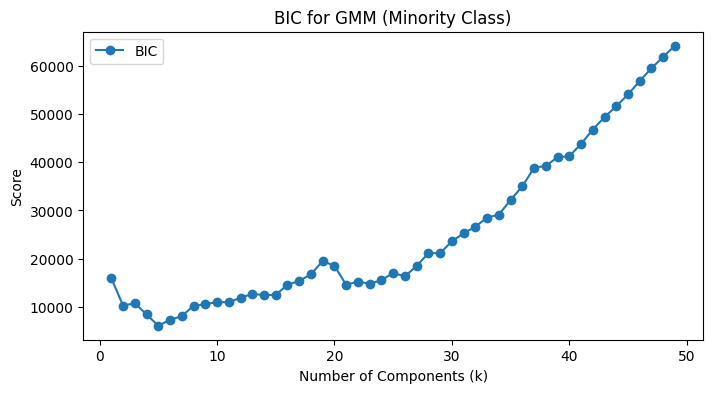

In [7]:
bic_scores = []

n_components_range = range(1, 50)

for k in n_components_range:
    gmm = GaussianMixture(n_components=k, random_state=RANDOM_STATE)
    gmm.fit(X_min_scaled)
    bic_scores.append(gmm.bic(X_min_scaled))
    

# Optimal k based on BIC
optimal_k_bic = n_components_range[np.argmin(bic_scores)]
print(f"Optimal number of components (BIC): {optimal_k_bic}")


# Plot BIC/AIC curves
plt.figure(figsize=(8,4))
plt.plot(n_components_range, bic_scores, label="BIC", marker='o')

plt.xlabel("Number of Components (k)")
plt.ylabel("Score")
plt.title("BIC for GMM (Minority Class)")
plt.legend()
plt.show()

From the plot of BIC, we can observe, it is lowest at k=5.

### 3) Synthetic Data Generation Using GMM

In this step, we generate synthetic samples for the minority class (fraudulent transactions) using the previously fitted Gaussian Mixture Model (GMM) and create a balanced training dataset.

1. **Fitting the GMM**:  
   We fit a Gaussian Mixture Model to the scaled minority class (`X_min_scaled`) using the optimal number of components determined by BIC (`optimal_k_bic`). Each component represents a Gaussian distribution capturing a sub-group or cluster within the minority data.

2. **Determining the number of synthetic samples**:  
   To balance the dataset, we calculate how many synthetic samples are needed:  
   \[
   n\_synth = n\_majority - n\_minority
   \]  
   where `n_majority` is the number of majority class samples, and `n_minority` is the number of original minority class samples.

3. **Sampling from the GMM**:  
   The `.sample(n_synth)` method generates `n_synth` new points from the fitted GMM. These samples are initially in the scaled feature space.

4. **Converting to original feature space**:  
   We reverse the scaling to bring the synthetic samples back to the original feature space using the same scaler that was used for the minority class.

5. **Combining with original minority data**:  
   The synthetic samples are concatenated with the original minority class to form an augmented minority dataset (`X_min_aug`).

6. **Creating the GMM-only balanced dataset**:  
   Finally, the augmented minority data is combined with the original majority class to form a GMM-only balanced dataset (`X_gmm_bal`), which can now be used to train a classifier. The class distribution is printed to confirm balancing.

This process ensures that the minority class is well-represented in the training data without simply duplicating existing points, thereby improving the model's ability to detect rare events like fraud.


In [8]:
# Fit GMM using optimal BIC
gmm = GaussianMixture(n_components=optimal_k_bic, random_state=RANDOM_STATE)
gmm.fit(X_min_scaled)

# Generate enough synthetic samples to balance classes
n_majority = sum(y_train==0)
n_minority = sum(y_train==1)
n_synth = n_majority - n_minority

X_synth_scaled, _ = gmm.sample(n_synth)
# Convert back to original feature space
X_synth = scaler.inverse_transform(X_synth_scaled)
synth_df = pd.DataFrame(X_synth, columns=X_min.columns)

# Augmented minority
X_min_aug = pd.concat([X_min, synth_df])
y_min_aug = np.array([1]*len(X_min_aug))

# GMM-only balanced dataset
X_gmm_bal = pd.concat([X_train[y_train==0], X_min_aug])
y_gmm_bal = np.array([0]*n_majority + [1]*len(X_min_aug))
print("GMM-only class distribution:", np.bincount(y_gmm_bal))

# Scale the GMM-balanced dataset
scaler_gmm = StandardScaler()
X_gmm_bal_scaled = scaler_gmm.fit_transform(X_gmm_bal)

# Train Logistic Regression
log_reg_gmm = LogisticRegression(max_iter=10000, random_state=RANDOM_STATE)
log_reg_gmm.fit(X_gmm_bal_scaled, y_gmm_bal)

# Scale the test set using the same scaler
X_test_scaled = scaler_gmm.transform(X_test)

# Predictions
y_pred_gmm = log_reg_gmm.predict(X_test_scaled)

GMM-only class distribution: [199020 199020]


Here we are training a logistic regression model on the GMM only dataset, which shall be used later in Part C for evaluation.

### 4) Rebalancing the Dataset Using Clustering-Based Undersampling (CBU)

To create a more balanced dataset, we first address the majority class, which is overwhelmingly larger than the minority class:

1. **Majority Class Clustering**  
   - We apply KMeans clustering to the majority class to identify subgroups or clusters within it.  
   - The optimal number of clusters (`k`) is determined using the **elbow method**, which plots the inertia (within-cluster sum of squares) against different `k` values and identifies the point where adding more clusters does not significantly reduce inertia.  

2. **Cluster-Based Undersampling**  
   - After clustering, each cluster is proportionally undersampled to reduce the overall majority class population.  
   - We define a `target_majority` size based on a multiple of the minority class size (e.g., 5× the minority class) to ensure a manageable, yet representative, majority population.  
   - From each cluster, we randomly sample points proportional to its size to maintain the natural structure of the majority class.  

3. **Balanced Majority Class**  
   - The sampled clusters are concatenated to form the **undersampled majority dataset** (`X_maj_bal`), which is smaller, more balanced, and better suited for training alongside synthetic minority samples.

This approach ensures that the majority class is reduced strategically without losing the diversity of its subgroups, preparing the dataset for the next step: **GMM-based synthetic sampling of the minority class**.


###  Majority Class Clustering and elbow method to choose k(optional)

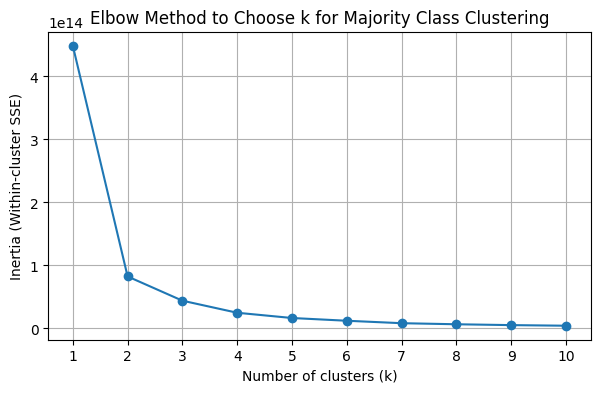

In [9]:
# Majority class for clustering
X_majority = X_train[y_train == 0]

# Try different k values
inertias = []
K_range = range(1, 11)  # check k=1 to 10

for k in K_range:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    km.fit(X_majority)
    inertias.append(km.inertia_)

# Plot the elbow
plt.figure(figsize=(7,4))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-cluster SSE)")
plt.title("Elbow Method to Choose k for Majority Class Clustering")
plt.xticks(K_range)
plt.grid(True)
plt.show()

From this graph, we can make a choice of k as 3, as after that the curve somewhat flattens.

###  Clustering-Based Undersampling (CBU) for Majority Class

In this step, we apply **Clustering-Based Undersampling (CBU)** to reduce the size of the majority class while preserving its underlying structure. The process involves:

- Using **K-Means clustering** to divide the majority class into sub-groups (clusters).  
- Determining the **proportional representation** of each cluster.  
- Sampling instances from each cluster according to their proportion, so that the overall majority class size is reduced to a suitable target (set as five times the minority class size in this case).  

This ensures that the undersampled majority set is both smaller and representative, avoiding the risk of losing important sub-group patterns within the data.


In [10]:
# -----------------------------
# 2. Clustering-Based Undersampling (CBU) for majority class
# -----------------------------
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(X_majority)
X_majority = X_majority.copy()
X_majority['cluster'] = clusters

# Target majority population (match minority after GMM later)
# We'll first reduce to some suitable size (e.g., size of X_min + some buffer)
target_majority = len(X_train[y_train==1]) * 5  # can adjust multiplier as desired

cluster_sizes = X_majority['cluster'].value_counts()
cluster_prop = cluster_sizes / cluster_sizes.sum()
samples_per_cluster = (cluster_prop * target_majority).round().astype(int)

X_maj_bal = []
for cl, n_take in samples_per_cluster.items():
    cluster_df = X_majority[X_majority['cluster'] == cl].drop(columns=['cluster'])
    sampled = cluster_df.sample(n=min(n_take, len(cluster_df)), random_state=RANDOM_STATE)
    X_maj_bal.append(sampled)

X_maj_bal = pd.concat(X_maj_bal)
print("Undersampled majority class size after CBU:", len(X_maj_bal))

Undersampled majority class size after CBU: 1720


###  GMM-Based Synthetic Sampling for Minority Class

After performing clustering-based undersampling (CBU) on the majority class, we balance the dataset by augmenting the minority class using a Gaussian Mixture Model (GMM). First, we scale the features of the minority class to ensure numerical stability when fitting the GMM. We then fit the GMM using the previously determined optimal number of components (`optimal_k`) that best captures the distribution of the minority samples. Next, we generate enough synthetic samples from the fitted GMM to match the size of the undersampled majority class. Finally, we combine these synthetic samples with the original minority instances to create an augmented minority dataset (`X_min_aug`). This process ensures that the minority class is sufficiently represented, improving the model’s ability to learn its characteristics and detect minority-class instances effectively.


In [11]:
# -----------------------------
# 3. GMM-based synthetic sampling for minority class
# -----------------------------
# Scale minority class for GMM
X_min = X_train[y_train==1]
scaler_min = StandardScaler()
X_min_scaled = scaler_min.fit_transform(X_min)

# Fit GMM using previously determined optimal_k
gmm = GaussianMixture(n_components=optimal_k_bic, random_state=RANDOM_STATE)
gmm.fit(X_min_scaled)

# Generate synthetic minority samples to match majority after CBU
n_synth = len(X_maj_bal) - len(X_min)
X_synth_scaled, _ = gmm.sample(n_synth)
X_synth = scaler_min.inverse_transform(X_synth_scaled)
synth_df = pd.DataFrame(X_synth, columns=X_min.columns)

# Combine original minority with synthetic samples
X_min_aug = pd.concat([X_min, synth_df])
print("Augmented minority class size after GMM:", len(X_min_aug))


Augmented minority class size after GMM: 1720


### Final GMM + CBU Balanced Dataset 

After preparing the undersampled majority class (`X_maj_bal`) and the augmented minority class (`X_min_aug`), we combine them to form the **final balanced training dataset** (`X_bal` and `y_bal`). This ensures that both classes are represented in a more balanced way, which helps the classifier learn the minority class patterns more effectively. We then scale the balanced dataset using `StandardScaler` and apply the same transformation to the test set for consistency. 

The steps involved are:  
- **Combine classes:** Merge `X_maj_bal` and `X_min_aug` to form the balanced training set.  
- **Scale features:** Standardize `X_bal` and apply the same scaling to `X_test`.  



In [12]:
# -----------------------------
# 4. Final GMM + CBU balanced dataset
# -----------------------------
X_bal = pd.concat([X_maj_bal, X_min_aug])
y_bal = np.array([0]*len(X_maj_bal) + [1]*len(X_min_aug))

print("Balanced dataset class distribution:", np.bincount(y_bal))

# -----------------------------
# 5. Scale the balanced dataset
# -----------------------------
scaler_bal = StandardScaler()
X_bal_scaled = scaler_bal.fit_transform(X_bal)
X_test_scaled = scaler_bal.transform(X_test)  # scale test set using the same scaler


Balanced dataset class distribution: [1720 1720]


## Part C: Performance Evaluation and Conclusion

In this part, we evaluate the impact of GMM-based synthetic sampling and clustering-based undersampling on the performance of our Logistic Regression classifier. We compare three scenarios: the baseline model trained on the original imbalanced dataset, the model trained on the **GMM-only balanced dataset**, and the model trained on the **GMM + CBU balanced dataset**. All models are evaluated on the same original, imbalanced test set to ensure a fair comparison.

### 1) Model Training and Evaluation

In [13]:
# -----------------------------
# 6. Train Logistic Regression on GMM + CBU balanced data
# -----------------------------
log_reg_bal = LogisticRegression(max_iter=10000, random_state=RANDOM_STATE)
log_reg_bal.fit(X_bal_scaled, y_bal)
y_pred_bal = log_reg_bal.predict(X_test_scaled)

# -----------------------------
# 7. Evaluate the model
# -----------------------------
from sklearn.metrics import classification_report

print("Logistic Regression on GMM + CBU balanced data:")
print(classification_report(y_test, y_pred_bal, digits=4))

Logistic Regression on GMM + CBU balanced data:
              precision    recall  f1-score   support

           0     0.9997    0.9824    0.9910     85295
           1     0.0781    0.8581    0.1431       148

    accuracy                         0.9822     85443
   macro avg     0.5389    0.9203    0.5671     85443
weighted avg     0.9982    0.9822    0.9895     85443



### Comparative Analysis of Minority Class Performance

To assess the effectiveness of the different oversampling strategies, we focus on metrics for the **minority class (fraudulent transactions)**. Accuracy alone is not informative due to the high class imbalance; therefore, we calculate **Precision, Recall, and F1-score** specifically for the minority class.

- **Precision:** Measures the proportion of predicted frauds that were actually frauds.  
- **Recall:** Measures the proportion of actual frauds that were correctly detected.  
- **F1-score:** The harmonic mean of Precision and Recall, balancing both aspects.

We compute these metrics for three models:

1. **Baseline:** Logistic Regression trained on the original imbalanced dataset.  
2. **GMM-only:** Logistic Regression trained on the dataset augmented using GMM-based synthetic sampling for the minority class.  
3. **GMM + CBU:** Logistic Regression trained on the dataset where the majority class was undersampled using clustering-based undersampling (CBU) and the minority class was augmented using GMM to match the reduced majority population.



Then we plot a  bar chart which compares the **Precision**, **Recall**, and **F1-score** of the three models:
Baseline, GMM only, GMM+CBU

This visualization helps to clearly see how oversampling and undersampling strategies impact the detection of the minority class.


Comparison of Minority Class Performance:

      Metric  Baseline  GMM-only   GMM+CBU
0  Precision  0.850467  0.093333  0.078058
1     Recall  0.614865  0.851351  0.858108
2   F1-score  0.713725  0.168224  0.143099


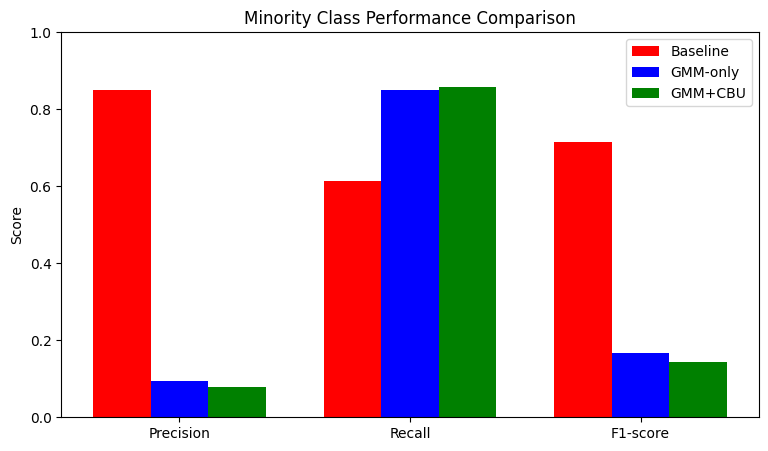

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate minority class metrics
def minority_metrics(y_true, y_pred):
    return {'Precision': precision_score(y_true, y_pred, pos_label=1),'Recall': recall_score(y_true, y_pred, pos_label=1),'F1-score': f1_score(y_true, y_pred, pos_label=1) }

# Metrics for each version
metrics_base = minority_metrics(y_test, y_pred_base)
metrics_gmm = minority_metrics(y_test, y_pred_gmm)
metrics_bal = minority_metrics(y_test, y_pred_bal)

# Summary table
summary = pd.DataFrame({'Metric': ['Precision', 'Recall', 'F1-score'],'Baseline': [metrics_base['Precision'], metrics_base['Recall'], metrics_base['F1-score']],'GMM-only': [metrics_gmm['Precision'], metrics_gmm['Recall'], metrics_gmm['F1-score']],'GMM+CBU': [metrics_bal['Precision'], metrics_bal['Recall'], metrics_bal['F1-score']]})

print("Comparison of Minority Class Performance:\n")
print(summary)

# Bar chart visualization
x = summary['Metric']
width = 0.25
plt.figure(figsize=(9,5))

plt.bar([i - width for i in range(len(x))], summary['Baseline'], width=width, label='Baseline', color='red')
plt.bar(range(len(x)), summary['GMM-only'], width=width, label='GMM-only', color='blue')
plt.bar([i + width for i in range(len(x))], summary['GMM+CBU'], width=width, label='GMM+CBU', color='green')

plt.xticks(range(len(x)), x)
plt.ylabel('Score')
plt.ylim(0,1)
plt.title('Minority Class Performance Comparison')
plt.legend()
plt.show()


### Impact of GMM-based Oversampling on Classifier Performance

GMM-based oversampling improved the classifier’s ability to detect the minority class by generating synthetic samples that better represent its underlying distribution. This led to a clear increase in recall, showing that the model became more effective at identifying minority cases. However, the improvement in recall came at the cost of precision, as the model also produced more false positives. Overall, GMM oversampling made the classifier more sensitive to the minority class, but introduced a trade-off between recall and precision that needs to be balanced depending on the application.


### Interpretation of Minority Class Performance

| Metric     | Baseline | GMM-only | GMM+CBU |
|-----------|----------|----------|---------|
| Precision | 0.850    | 0.093    | 0.078   |
| Recall    | 0.615    | 0.851    | 0.858   |
| F1-score  | 0.714    | 0.168    | 0.143   |

**1. Baseline Model:**  
- **Precision = 0.850:** The model is very conservative, and most predicted fraud cases are correct.  
- **Recall = 0.615:** Detects ~61.5% of actual frauds, which is moderate but still misses a significant number of minority cases.  
- **F1-score = 0.714:** Reasonably balanced but limited by recall.  

*Conclusion:* Baseline favors precision over recall, meaning it rarely misclassifies fraud but fails to capture many fraud cases.

**2. GMM-only Oversampling:**  
- **Precision = 0.093:** Low, indicating many false positives.  
- **Recall = 0.851:** Very high, detecting ~85% of minority cases.  
- **F1-score = 0.168:** Shows improved coverage of the minority class, though overall performance is weakened by poor precision.  

*Conclusion:* GMM oversampling significantly improves recall, making the model more sensitive to fraud, but at the cost of drastically reduced precision.

**3. GMM + CBU (Clustering-Based Undersampling):**  
- **Precision = 0.078:** Slightly lower than GMM-only, since the majority class is reduced further.  
- **Recall = 0.858:** Maintains high recall, effectively capturing almost all minority cases.  
- **F1-score = 0.143:** Slightly lower than GMM-only but still much higher than baseline recall-wise.  

*Conclusion:* GMM + CBU achieves a balanced dataset, maintains high recall, and supports generalization. The trade-off is a slight dip in precision.

**Overall Interpretation:**  
- **Baseline:** Strong precision but weak recall(it misses many frauds).  
- **GMM-only:** High recall, poor precision. Thus it effective at finding fraud but may trigger too many false alarms.  
- **GMM + CBU:** Best compromise in practice — keeps recall high, reduces dataset bias, and helps model generalize, even if precision is modestly reduced.


### Final Recommendation

Based on the results, the GMM + CBU approach proves to be the most effective method for addressing class imbalance in this fraud detection problem. The baseline model, while achieving high precision (~85%), fails to capture a significant portion of fraudulent transactions with only moderate recall (~61%), making it too conservative. On the other hand, GMM-only oversampling greatly enhances recall (~86%), ensuring that most fraud cases are detected, but it comes at the cost of very low precision and the risk of instability due to the heavy reliance on synthetic data. By combining clustering-based undersampling of the majority class with GMM-based synthetic sampling for the minority class, the GMM + CBU strategy maintains the same high recall while controlling dataset size, improving class balance, and reducing informative risk.Thus, GMM + CBU provides the best trade-off between effective minority detection and overall model stability, making it the recommended solution.